## AMPTH 207: Stochastic Methods for Data Analysis, Inference and Optimization

### Long Homework 1

**Harvard University**  
**Spring 2017**  
**Instructor: Rahul Dave**  
**Due Date:** Thursday, Febrary 23rd, 2017 at 11:59pm

**Instructions:**

- Upload your final answers as well as your iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

## Premise

In supervised machine learning, a function that maps certain input data to a set of outputs is inferred from a labelled dataset called the training set, and the resulting learnt funtion is then used to make predictions on unseen new examples of the dataset (the test set).

The goal of this homework is to construct a classifier known as the single-hidden-layer Multi-Layer Perceptron (MLP), an artificial neural netwok. You are asked to train the classifier using mini-batch gradient descent, validate it, and then apply it to a test dataset to make predictions. We will use the [*MNIST* dataset](https://en.wikipedia.org/wiki/MNIST_database), which consists of 70,000 images of handwritten digits, each of which is 28x28 pixels. You can use the first 50,000 images as the training set, the next 10,000 images as the validation set, and the last 10,000 images as the test set.

You will proceed in 2 steps (each step is a problem) to build the MLP. Please use Theano to program the classifiers.

## Problem 1. Stochastic gradient descent for the logistic regresion

First, build a logistic regression classifier whose input is the array of pixel values in one image, and whose output is the most likely class of the vector. In order to familiarize yourself with the dataset, plot some of the images beforehand, and think about the pixel values as features of the input vector.

### Part A

Using the softmax formulation, write a Theano expression graph that:
* Calculates the probability of a target element belonging to class $i$ (i.e., the probability that a given image represents a digit between 0 and 9).
* Maximizes it over all classes, and computes the cost function using an L2 regularization approach
* Minimizes the resulting cost function using mini-batch gradient descent. How long does it take for your code to train with 50,000 training examples of the dataset?

*Hint: Use a batch size of 256 examples, a learning rate $\eta = 0.1$, and a regularization factor $\lambda=0.01$*.

### Part B

* Evaluate the validation loss function periodically as you train the classifier and plot it as a function of the epoch. Plot this loss function for several values of the regularization factor.
* When should you stop the training for different values of $\lambda$? Give an approximate answer supported by using the plots.
* Select what you consider the best regularization factor and predict the classes of the test set. Compare with the given labels. What is the test error that you obtain?

# IMPORT LIBRARIES AND SET UP THE DATA

In [1]:
import pandas as pd
import time
import numpy as np
import math

import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['legend.fontsize'] = 14
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
%matplotlib inline

sns.set_style("darkgrid")
plt.style.use('ggplot')

# disable warnings
import warnings
warnings.simplefilter('ignore')

# imports for long hw 1
import gzip
import pickle
import theano
from theano import function, pp, shared
import theano.tensor as T

# To read the dataset
dataset='mnist.pkl.gz'
with gzip.open(dataset, 'rb') as f:
        try:
            train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
        except:
            train_set, valid_set, test_set = pickle.load(f)

# 1a

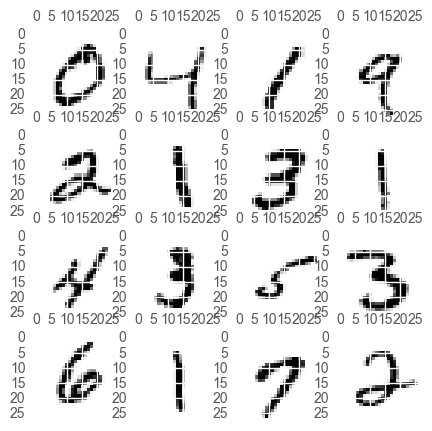

In [2]:
# plot a selection of the images and think about them beforehand
fig = plt.figure(figsize=(5,5))
for i in range(1,17):
    pixels = train_set[0][i]
    pixels = np.array(pixels)
    image = pixels.reshape((28, 28))
    ax = fig.add_subplot(4,4,i)
    imgplot = ax.imshow(image, cmap=mpl.cm.Greys)
    imgplot.set_interpolation('nearest')
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
plt.show()

# Set up Theano Graph

In [3]:
def shared_dataset(data_xy, borrow=True):
    data_x, data_y = data_xy
    shared_x = theano.shared(np.asarray(data_x,
                                           dtype=theano.config.floatX),
                             borrow=borrow)
    shared_y = theano.shared(np.asarray(data_y,
                                           dtype=theano.config.floatX),
                             borrow=borrow)

    return shared_x, T.cast(shared_y, 'int32')
   
test_set_x, test_set_y = shared_dataset(test_set)
valid_set_x, valid_set_y = shared_dataset(valid_set)
train_set_x, train_set_y = shared_dataset(train_set)

#=====================#
#set up parameters #
#=====================#

# size of the minibatch
batch_size = 256

n_train_batches = train_set[0].shape[0] // batch_size
n_valid_batches = valid_set[0].shape[0] // batch_size
n_test_batches = test_set[0].shape[0] // batch_size

learning_rate = 0.1

L2_reg = 0.01
n_in=28 * 28
n_out=10

#==========================#
# Setting up Theano Graph  #
#==========================#

x = T.matrix('x')  # data, presented as rasterized images
y = T.ivector('y')  # labels, presented as 1D vector of [int] labels

W = theano.shared(value=np.zeros((n_in, n_out),
                    dtype=theano.config.floatX),
                name='W',
                borrow=True
            )
b = theano.shared(value=np.zeros(
                    (n_out,),
                    dtype=theano.config.floatX
                ),
                name='b',
                borrow=True
            )

p_y_given_x = T.nnet.softmax(T.dot(x, W) + b)   
y_pred = T.argmax(p_y_given_x, axis=1)
params = [W, b]
L2_sqr = T.sum((W ** 2))
log_likelihood = -T.mean(T.log(p_y_given_x)[T.arange(y.shape[0]), y])
errors = T.mean(T.neq(y_pred, y))

cost = (log_likelihood+ L2_reg * L2_sqr)   
g_W = T.grad(cost=cost, wrt=W)
g_b = T.grad(cost=cost, wrt=b)
updates = [(W, W - learning_rate * g_W),
           (b, b - learning_rate * g_b)]

# Build the model and run the computation...

In [4]:
index = T.lscalar()

# train the model using logistic regression 
train_model = theano.function(
        inputs=[index],
        outputs=cost,
        updates=updates,
        givens={
            x: train_set_x[index * batch_size: (index + 1) * batch_size],
            y: train_set_y[index * batch_size: (index + 1) * batch_size]
        }
    )  
avg_cost = []

# model trained, start the timer and run
start_time = time.time()

for minibatch_index in range(n_train_batches):
    minibatch_avg_cost = train_model(minibatch_index)
    avg_cost.append(minibatch_avg_cost)

print("The time taken to run, based on training 50k examples, for one epoch was %f seconds" % (time.time() - start_time))

The time taken to run, based on training 50k examples, for one epoch was 0.081252 seconds


# Demonstrate the decrease in the cost function

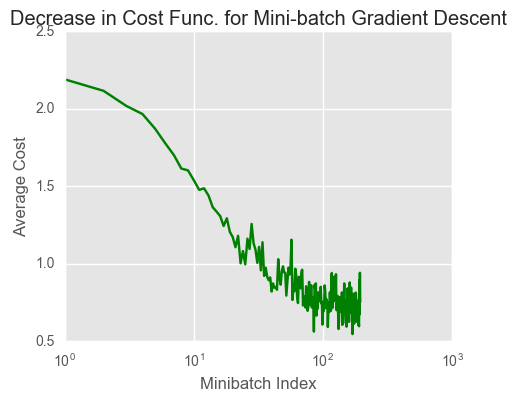

In [5]:
plt.figure(figsize = [5,4])
plt.semilogx(range(len(avg_cost)),avg_cost,color='g')
plt.title('Decrease in Cost Func. for Mini-batch Gradient Descent')
plt.xlabel('Minibatch Index')
plt.ylabel('Average Cost')

# different regularization factors to evaluate the validation loss func.

In [6]:
# set the provided learning rate
learning_rate = 0.1

# a set for the reg. factors
L2_set = [0.01,0.05,0.1,1]

# Each MNIST image has size 28*28 
n_in=28 * 28
n_out=10

avg_cost_set = []

# iterate over the set of reg. factors
for L2_reg in L2_set:  
    
    #==========================#
    # set up Theano Graph  #
    #==========================#
    
    x = T.matrix('x')  # data, presented as rasterized images
    y = T.ivector('y')  # labels, presented as 1D vector of [int] labels

    W = theano.shared(value=np.zeros((n_in, n_out),
                        dtype=theano.config.floatX),
                    name='W',
                    borrow=True
                )
    b = theano.shared(value=np.zeros(
                        (n_out,),
                        dtype=theano.config.floatX
                    ),
                    name='b',
                    borrow=True
                )

    p_y_given_x = T.nnet.softmax(T.dot(x, W) + b)   
    y_pred = T.argmax(p_y_given_x, axis=1)
    params = [W, b]
    
    # symbolic Theano variable that represents the squared L2 term
    L2_sqr = T.sum(W ** 2)
    
    log_likelihood = -T.mean(T.log(p_y_given_x)[T.arange(y.shape[0]), y])
    errors = T.mean(T.neq(y_pred, y))

    cost = (log_likelihood + L2_reg * L2_sqr)   
    g_W = T.grad(cost=cost, wrt=W)
    g_b = T.grad(cost=cost, wrt=b)
    updates = [(W, W - learning_rate * g_W),
               (b, b - learning_rate * g_b)]

    # build actual model 
    # allocate symbolic variables for the data
    index = T.lscalar()
    
    # compile a Theano function to train the model through logistic regression 
    train_model = theano.function(
            inputs=[index],
            outputs=cost,
            updates=updates,
            givens={
                x: train_set_x[index * batch_size: (index + 1) * batch_size],
                y: train_set_y[index * batch_size: (index + 1) * batch_size]
            }
        )
    
    # calculate the validation loss by using the current weights matrix and errors vector
    validate_model = theano.function(
                inputs=[index],
                outputs=errors,
                givens={
                    x: valid_set_x[index * batch_size: (index + 1) * batch_size],
                    y: valid_set_y[index * batch_size: (index + 1) * batch_size]
                }
            )

    # Run the model batch by batch, calculating the costs to analyze how the average cost decreases over time 
    avg_cost = []

    done_looping = False
    epoch = 0
    n_epochs=100
    validation_frequency = 100
    
    # run the algorithm
    while (epoch < n_epochs) and (not done_looping):
        epoch = epoch + 1
        for minibatch_index in range(n_train_batches):

            minibatch_avg_cost = train_model(minibatch_index)

            # iteration number
            iter = (epoch - 1) * n_train_batches + minibatch_index

            if (iter + 1) % validation_frequency == 0:
                
                # compute zero-one loss on validation set
                validation_losses = [validate_model(i)
                                     for i in range(n_valid_batches)]
                this_validation_loss = np.mean(validation_losses)
                avg_cost.append(this_validation_loss)

        if epoch == n_epochs:
            done_looping = True
            avg_cost_set.append(avg_cost)
            break

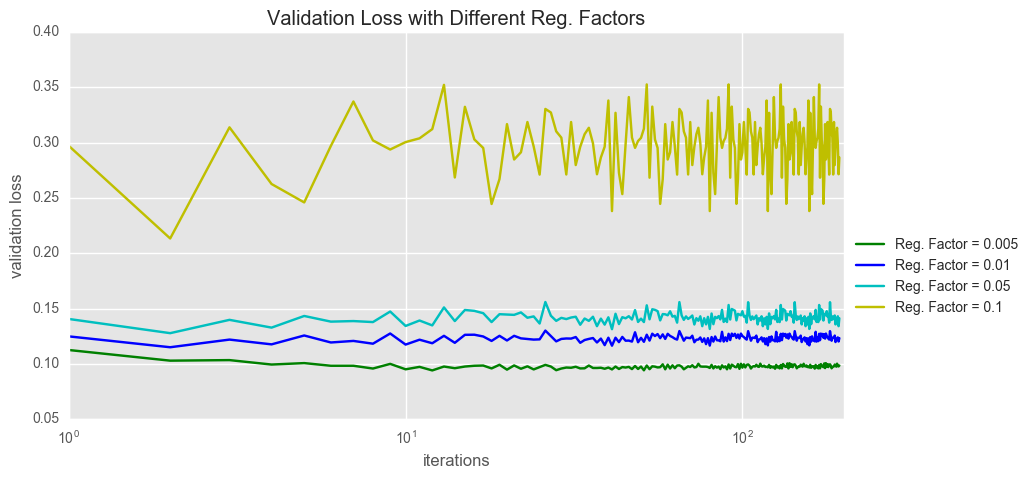

In [7]:
plt.figure(figsize = [10,5])
plt.semilogx(range(len(avg_cost_set[0])),avg_cost_set[0],'g',label=u'Reg. Factor = 0.005')
plt.semilogx(range(len(avg_cost_set[1])),avg_cost_set[1],'b',label=u'Reg. Factor = 0.01')
plt.semilogx(range(len(avg_cost_set[2])),avg_cost_set[2],'c',label=u'Reg. Factor = 0.05')
plt.semilogx(range(len(avg_cost_set[3])),avg_cost_set[3],'y',label=u'Reg. Factor = 0.1')
plt.xlim([0,200])
plt.title('Validation Loss with Different Reg. Factors')
plt.xlabel('iterations')
plt.ylabel('validation loss')
plt.legend(loc='best', bbox_to_anchor=(1, 0.5))

In [8]:
# a set for the reg. factors
L2_set = [0.01,0.05,0.1,1]

# a list for the early stop calculations
avg_cost_early_stop = []

patience_num = []

# iterate over the set of reg. factors
for L2_reg in L2_set:
    #==========================#
    # set up Theano Graph  #
    #==========================#
    
    x = T.matrix('x')  # data, presented as rasterized images
    y = T.ivector('y')  # labels, presented as 1D vector of [int] labels

    W = theano.shared(value=np.zeros((n_in, n_out),
                        dtype=theano.config.floatX),
                    name='W',
                    borrow=True
                )
    b = theano.shared(value=np.zeros(
                        (n_out,),
                        dtype=theano.config.floatX
                    ),
                    name='b',
                    borrow=True
                )

    p_y_given_x = T.nnet.softmax(T.dot(x, W) + b)   
    y_pred = T.argmax(p_y_given_x, axis=1)
    params = [W, b]
    
    # symbolic Theano variable that represents the squared L2 term
    L2_sqr = T.sum(W ** 2)
    
    log_likelihood = -T.mean(T.log(p_y_given_x)[T.arange(y.shape[0]), y])
    errors = T.mean(T.neq(y_pred, y))

    cost = (log_likelihood+ L2_reg * L2_sqr)   
    g_W = T.grad(cost=cost, wrt=W)
    g_b = T.grad(cost=cost, wrt=b)
    updates = [(W, W - learning_rate * g_W),
               (b, b - learning_rate * g_b)]

    # build actual model
    # allocate symbolic variables for the data
    index = T.lscalar()
    
    # compile a Theano function to train the model through logistic regression 
    train_model = theano.function(
            inputs=[index],
            outputs=cost,
            updates=updates,
            givens={
                x: train_set_x[index * batch_size: (index + 1) * batch_size],
                y: train_set_y[index * batch_size: (index + 1) * batch_size]
            }
        )
    
    # calculate the validation loss by using the current weights matrix and errors vector
    validate_model = theano.function(
                inputs=[index],
                outputs=errors,
                givens={
                    x: valid_set_x[index * batch_size: (index + 1) * batch_size],
                    y: valid_set_y[index * batch_size: (index + 1) * batch_size]
                }
            )

    # Run the model batch by batch, calculating the costs to analyze how the average cost decreases over time 
    avg_cost = []

    # initialize the running process for the model 
    epoch = 0
    n_epochs=100
    validation_frequency = 100
    best_validation_loss = np.inf
    
    # define the threshold for how much of an improvement is considered significant
    improvement_threshold = 0.995
    
    # early stopping parameters 
    # wait this much longer when a new best is found
    patience_increase = 2
    # look at this many examples regardless
    patience = 5000
    
    done_looping = False

    while (epoch < n_epochs) and (not done_looping):
        epoch = epoch + 1
        for minibatch_index in range(n_train_batches):
    
            minibatch_avg_cost = train_model(minibatch_index)
            
            # iteration number
            iter = (epoch - 1) * n_train_batches + minibatch_index
    
            if (iter + 1) % validation_frequency == 0:
                # compute zero-one loss on validation set
                validation_losses = [validate_model(i)
                                     for i in range(n_valid_batches)]
                this_validation_loss = np.mean(validation_losses)
                avg_cost.append(this_validation_loss)
                
                if this_validation_loss < best_validation_loss:

                    if this_validation_loss < best_validation_loss * improvement_threshold:
                        patience = max(patience, iter * patience_increase)
                    
                    best_validation_loss = this_validation_loss        
                
        if patience <= iter:
            patience_num.append(iter)
            done_looping = True
            avg_cost_early_stop.append(avg_cost)
            break

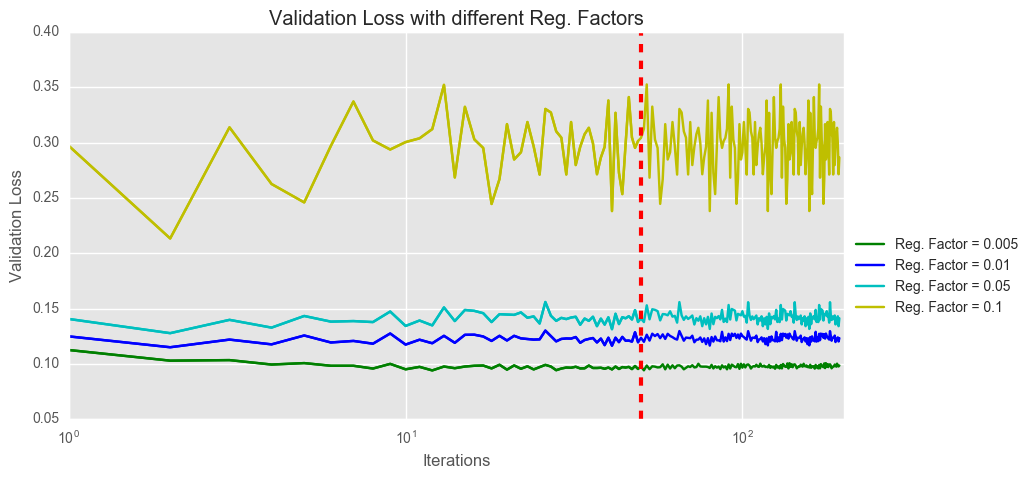

In [9]:
plt.figure(figsize = [10,5])

# plot the validation loss function with no early stop function
plt.semilogx(range(len(avg_cost_set[0])),avg_cost_set[0],'g',label=u'Reg. Factor = 0.005')
plt.semilogx(range(len(avg_cost_set[1])),avg_cost_set[1],'b',label=u'Reg. Factor = 0.01')
plt.semilogx(range(len(avg_cost_set[2])),avg_cost_set[2],'c',label=u'Reg. Factor = 0.05')
plt.semilogx(range(len(avg_cost_set[3])),avg_cost_set[3],'y',label=u'Reg. Factor = 0.1')

# plot the validation loss function using an early stop function
plt.semilogx(range(len(avg_cost_early_stop[0])),avg_cost_early_stop[0],'g')
plt.semilogx(range(len(avg_cost_early_stop[1])),avg_cost_early_stop[1],'b')
plt.semilogx(range(len(avg_cost_early_stop[2])),avg_cost_early_stop[2],'c')
plt.semilogx(range(len(avg_cost_early_stop[3])),avg_cost_early_stop[3],'y')
plt.xlim([0,200])
plt.title('Validation Loss with different Reg. Factors')
plt.xlabel('Iterations')
plt.ylabel('Validation Loss')

# set a verticle line to display the stopping point
plt.axvline(x=len(avg_cost_early_stop[3]), linewidth=3, color='r',ls='dashed')
plt.legend(loc='best', bbox_to_anchor=(1, 0.5))

The plot above displays validation loss with early stop function.  To the right of the red dashed line are validation loss without early stop funciton.  To the left of the red dashed line displays an early stop occuring around epoch 25.

# 1b - Select what you consider the best regularization factor and predict the classes of the test set. Compare with the given labels. What is the test error that you obtain?

Here I looked for the factor with the smallet variance and overall validation loss, which is 0.005 based on the above plot.

In [10]:
# use my selected reg. factor
L2_reg = 0.005

#==========================#
# set up Theano Graph  #
#==========================#

x = T.matrix('x')  # data, presented as rasterized images
y = T.ivector('y')  # labels, presented as 1D vector of [int] labels

W = theano.shared(value=np.zeros((n_in, n_out),
                    dtype=theano.config.floatX),
                name='W',
                borrow=True
            )
b = theano.shared(value=np.zeros(
                    (n_out,),
                    dtype=theano.config.floatX
                ),
                name='b',
                borrow=True
            )

p_y_given_x = T.nnet.softmax(T.dot(x, W) + b)   
y_pred = T.argmax(p_y_given_x, axis=1)
params = [W, b]

# symbolic Theano variable that represents the squared L2 term
L2_sqr = T.sum(W ** 2)

log_likelihood = -T.mean(T.log(p_y_given_x)[T.arange(y.shape[0]), y])
errors = T.mean(T.neq(y_pred, y))

cost = (log_likelihood+ L2_reg * L2_sqr)   
g_W = T.grad(cost=cost, wrt=W)
g_b = T.grad(cost=cost, wrt=b)
updates = [(W, W - learning_rate * g_W),
           (b, b - learning_rate * g_b)]

# build actual model
# allocate symbolic variables for the data
index = T.lscalar()

# compile a Theano function to train the model through logistic regression 
train_model = theano.function(
        inputs=[index],
        outputs=cost,
        updates=updates,
        givens={
            x: train_set_x[index * batch_size: (index + 1) * batch_size],
            y: train_set_y[index * batch_size: (index + 1) * batch_size]
        }
    )

# calculate the validation loss by using the current weights matrix and errors vector
validate_model = theano.function(
            inputs=[index],
            outputs=errors,
            givens={
                x: valid_set_x[index * batch_size: (index + 1) * batch_size],
                y: valid_set_y[index * batch_size: (index + 1) * batch_size]
            }
        )

#testing the function
test_model = theano.function(
    inputs=[index],
    outputs=errors,
    givens={
        x: test_set_x[index * batch_size: (index + 1) * batch_size],
        y: test_set_y[index * batch_size: (index + 1) * batch_size]})

# Run the model batch by batch, calculating the costs to analyze how the average cost decreases over time 
avg_cost = []

# run the model 
epoch = 0
n_epochs=100
validation_frequency = 100
best_validation_loss = np.inf

# define the threshold for how much of an improvement is considered significant
improvement_threshold = 0.995

# early stopping parameters 
# wait this much longer when a new best is found
patience_increase = 2
# look at this many examples regardless
patience = 5000

done_looping = False

while (epoch < n_epochs) and (not done_looping):
    epoch = epoch + 1
    for minibatch_index in range(n_train_batches):

        minibatch_avg_cost = train_model(minibatch_index)

        # iteration number
        iter = (epoch - 1) * n_train_batches + minibatch_index

        if (iter + 1) % validation_frequency == 0:
            # compute zero-one loss on validation set
            validation_losses = [validate_model(i)
                                 for i in range(n_valid_batches)]
            this_validation_loss = np.mean(validation_losses)
            avg_cost.append(this_validation_loss)

            if this_validation_loss < best_validation_loss:

                if this_validation_loss < best_validation_loss * improvement_threshold:
                    patience = max(patience, iter * patience_increase)

                best_validation_loss = this_validation_loss        

    if patience <= iter:
        patience_num.append(iter)
        done_looping = True
        avg_cost_early_stop.append(avg_cost)
        break

test_losses = [test_model(i)for i in range(n_test_batches)]
test_score = np.mean(test_losses)
print('The test error was',test_score)

The test error was 0.0931490384615


## Problem 2. The Multilayer Perceptron (with one hidden layer)
The multilayer perceptron can be understood as a logistic regression classifier in which the input is first transformed using a learnt non-linear transformation. The non-linear transformation is usually chosen to be either the logistic function or the $\tanh$ function, and its purpose is to project the data into a space where it becomes linealry separable The output of this so-called hidden layer is then passed to the logistic regression graph that we have constructed in the first problem. In matrix notation:

$$G(b^{(2)}+W^{(2)}(s(b^{(1)}W^{(1)}x)))$$

with bias vectors $b^{(1)}$, $b^{(2)}$; weight matrices $W^{(1)}$, $W^{(2)}$ and activation functions $G$ and $s$. Here is a diagram:

<td><img src="http://deeplearning.net/tutorial/_images/mlp.png", width=300, height=300></td>

### Part A

Using a similar architecture as in the first part and the same MNIST dataset, built a Theano graph for the multilayer perceptron, using the $\tanh$ function as the non-linearity. Use $\eta = 0.1$ and $\lambda = 0.001$. Experiment with the batch size (use 20, 50, and 100 examples) and the number of units in your hidden layer (use 50, 100, and 200 units). For what combination of these parameters do you obtain the smallest value of the validation loss function after 50 epochs?

### Part B

Stop the trainning at a convenient validation loss and use the trained classifier to predict for the test set. How much better is your test error as compared to the logistic regression classifier?

*Hint 1:* The initialization of the weights matrix for the hidden layer must assure that the units (neurons) of the perceptron operate in a regime where information gets propagated. For the $\tanh$ function, it is advisable to initialize with the interval $[-\sqrt{\frac{6}{fan_{in}+fan_{out}}},\sqrt{\frac{6}{fan_{in}+fan_{out}}}]$, where $fan_{in}$ is the number of units in the $(i-1)$-th layer, and $fan_{out}$ is the number of units in the i-th layer.

*Hint 2:* You should feel free to get inspiration from [these tutorials](http://deeplearning.net/tutorial/mlp.html). However, we expect you to write your own code, inspired by the architecture shown in the lab.




# 2a

In [17]:
#=====================#
#set up parameters #
# using testing combinations of 20,50,100 for batch sizes and 50,100,200 for hidden units
#=====================#
batch_size_set = [20,50,100]
hidden_set = [50,100,200]

for batch_size in batch_size_set:
    for n_hidden in hidden_set:

        n_train_batches = train_set[0].shape[0] // batch_size
        n_valid_batches = valid_set[0].shape[0] // batch_size
        n_test_batches = test_set[0].shape[0] // batch_size

        # set the provided learning rate and reg. factor
        learning_rate = 0.1
        L2_reg = 0.001

        class HiddenLayer(object):
            def __init__(self, rng, input, n_in, n_out, W=None, b=None,
                         activation=T.tanh):

                self.input = input

                if W is None:
                    W_values = np.asarray(
                        rng.uniform(
                            #adding the initializing level as suggested in the guidelines
                            low=-np.sqrt(6. / (n_in + n_out)),
                            high=np.sqrt(6. / (n_in + n_out)),
                            size=(n_in, n_out)
                        ),
                        dtype=theano.config.floatX
                    )
                    if activation == theano.tensor.nnet.sigmoid:
                        W_values *= 4

                    W = theano.shared(value=W_values, name='W', borrow=True)

                if b is None:
                    b_values = np.zeros((n_out,), dtype=theano.config.floatX)
                    b = theano.shared(value=b_values, name='b', borrow=True)

                self.W = W
                self.b = b

                lin_output = T.dot(input, self.W) + self.b
                self.output = (
                    lin_output if activation is None
                    else activation(lin_output)
                )
                # parameters of the model
                self.params = [self.W, self.b]

        #=====================#
        # create the Multi-class Logistic Regression Class
        #=====================#

        class LogisticRegression(object):

            def __init__(self, input, n_in, n_out):
                # initialize with 0 the weights W as a matrix of shape (n_in, n_out)
                self.W = theano.shared(
                    value=np.zeros(
                        (n_in, n_out),
                        dtype=theano.config.floatX
                    ),
                    name='W',
                    borrow=True
                )
                # initialize the biases b as a vector of n_out 0s
                self.b = theano.shared(
                    value=np.zeros(
                        (n_out,),
                        dtype=theano.config.floatX
                    ),
                    name='b',
                    borrow=True
                )

                # symbolic expression for computing the matrix of class-membership
                # probabilities
                self.p_y_given_x = T.nnet.softmax(T.dot(input, self.W) + self.b)

                # symbolic description of how to compute prediction as class whose
                # probability is maximal
                self.y_pred = T.argmax(self.p_y_given_x, axis=1)
                # end-snippet-1

                # parameters of the model
                self.params = [self.W, self.b]

                # keep track of model input
                self.input = input

                #computing sum of squares of paramters 
                # symbolic Theano variable that represents the squared L2 term
                self.L2_sqr = T.sum(self.W ** 2)

            def negative_log_likelihood(self, y):
                """Return the mean of the negative log-likelihood of the prediction
                of this model under a given target distribution.
                """
                return -T.mean(T.log(self.p_y_given_x)[T.arange(y.shape[0]), y])

            def errors(self, y):
                """Return a float representing the number of errors in the minibatch
                over the total number of examples of the minibatch ; zero one
                loss over the size of the minibatch
                """

                # check if y has same dimension of y_pred
                if y.ndim != self.y_pred.ndim:
                    raise TypeError(
                        'y should have the same shape as self.y_pred',
                        ('y', y.type, 'y_pred', self.y_pred.type)
                    )
                # check if y is of the correct datatype
                if y.dtype.startswith('int'):
                    # the T.neq operator returns a vector of 0s and 1s, where 1
                    # represents a mistake in prediction
                    return T.mean(T.neq(self.y_pred, y))
                else:
                    raise NotImplementedError()

        class MLP(object):

            def __init__(self, rng, input, n_in, n_hidden, n_out):

                self.hiddenLayer = HiddenLayer(
                    rng=rng,
                    input=input,
                    n_in=n_in,
                    n_out=n_hidden,
                    activation=T.tanh
                )

                self.logRegressionLayer = LogisticRegression(
                    input=self.hiddenLayer.output,
                    n_in=n_hidden,
                    n_out=n_out
                )

                self.L2_sqr = (
                    T.sum(self.hiddenLayer.W ** 2)
                    + T.sum(self.logRegressionLayer.W ** 2)
                )

                # negative log likelihood of the MLP is given by the negative
                # log likelihood of the output of the model, computed in the
                # logistic regression layer
                self.negative_log_likelihood = (
                    self.logRegressionLayer.negative_log_likelihood
                )
                # same holds for the function computing the number of errors
                self.errors = self.logRegressionLayer.errors

                # the parameters of the model are the parameters of the two layer it is
                # made out of
                self.params = self.hiddenLayer.params + self.logRegressionLayer.params


                # keep track of model input
                self.input = input

        #######################
        # READY TO BUILD THE ACTUAL MODEL #
        ######################
        index = T.lscalar()
        x = T.matrix('x')  # data, presented as rasterized images
        y = T.ivector('y')  # labels, presented as 1D vector of [int] labels
        rng = np.random.RandomState(1234)

        # construct the MLP class
        classifier = MLP(
            rng=rng,
            input=x,
            n_in=28 * 28,
            n_hidden=n_hidden,
            n_out=10
        )
        
        cost = (classifier.negative_log_likelihood(y) + L2_reg * classifier.L2_sqr)


        # compiling a Theano function that computes the mistakes that are made
        # by the model on a minibatch
        test_model = theano.function(
            inputs=[index],
            outputs=classifier.errors(y),
            givens={
                x: test_set_x[index * batch_size:(index + 1) * batch_size],
                y: test_set_y[index * batch_size:(index + 1) * batch_size]
            }
        )

        validate_model = theano.function(
            inputs=[index],
            outputs=classifier.errors(y),
            givens={
                x: valid_set_x[index * batch_size:(index + 1) * batch_size],
                y: valid_set_y[index * batch_size:(index + 1) * batch_size]
            }
        )

        # compute the gradient of cost with respect to theta (sorted in params)
        gparams = [T.grad(cost, param) for param in classifier.params]

        # specify how to update the parameters of the model as a list of
        updates = [(param, param - learning_rate * gparam)
            for param, gparam in zip(classifier.params, gparams)]

        # compiling a Theano function `train_model` that returns the cost, but
        # in the same time updates the parameter of the model based on the rules
        # defined in `updates`
        train_model = theano.function(
            inputs=[index],
            outputs=cost,
            updates=updates,
            givens={
                x: train_set_x[index * batch_size: (index + 1) * batch_size],
                y: train_set_y[index * batch_size: (index + 1) * batch_size]
            }
        )

        start_time = time.time()

        n_epochs = 50
        epoch = 0
        done_looping = False
        avg_cost = []
        validation_frequency = 100

        while (epoch < n_epochs) and (not done_looping):

            epoch = epoch + 1

            for minibatch_index in range(n_train_batches):
                minibatch_avg_cost = train_model(minibatch_index)
                # iteration number
                iter = (epoch - 1) * n_train_batches + minibatch_index

                if (iter + 1) % validation_frequency == 0:
                    # compute zero-one loss on validation set
                    validation_losses = [validate_model(i) for i in range(n_valid_batches)]
                    this_validation_loss = np.mean(validation_losses)
                    avg_cost.append(this_validation_loss)

            if epoch == n_epochs:
                done_looping = True
                avg_cost.append(this_validation_loss)
                break

        print("PROCESSING TIME = %f seconds" % (time.time() - start_time))
        print("\t","BATCH SIZE =",batch_size," HIDDEN UNITS =", n_hidden,"VALIDATION LOSS =", avg_cost[-1],"\n")

PROCESSING TIME = 135.369832 seconds
	 BATCH SIZE = 20  HIDDEN UNITS = 50 VALIDATION LOSS = 0.0372 

PROCESSING TIME = 196.814288 seconds
	 BATCH SIZE = 20  HIDDEN UNITS = 100 VALIDATION LOSS = 0.0342 

PROCESSING TIME = 313.430217 seconds
	 BATCH SIZE = 20  HIDDEN UNITS = 200 VALIDATION LOSS = 0.0345 

PROCESSING TIME = 49.557566 seconds
	 BATCH SIZE = 50  HIDDEN UNITS = 50 VALIDATION LOSS = 0.0335 

PROCESSING TIME = 78.532487 seconds
	 BATCH SIZE = 50  HIDDEN UNITS = 100 VALIDATION LOSS = 0.0316 

PROCESSING TIME = 145.772572 seconds
	 BATCH SIZE = 50  HIDDEN UNITS = 200 VALIDATION LOSS = 0.0325 

PROCESSING TIME = 30.402599 seconds
	 BATCH SIZE = 100  HIDDEN UNITS = 50 VALIDATION LOSS = 0.0338 

PROCESSING TIME = 51.134015 seconds
	 BATCH SIZE = 100  HIDDEN UNITS = 100 VALIDATION LOSS = 0.0318 

PROCESSING TIME = 90.017562 seconds
	 BATCH SIZE = 100  HIDDEN UNITS = 200 VALIDATION LOSS = 0.033 



The best results occurred with a running time of 78 seconds. This was obtained with a batch size of 50 and 100 hidden units, and resulted in the lowest validation loss at 3.16%

In [18]:
#=====================#
#set up parameters - use the best settings from the experiment above #
#=====================#
batch_size_set = [50]
hidden_set = [100]

for batch_size in batch_size_set:
    for n_hidden in hidden_set:

        n_train_batches = train_set[0].shape[0] // batch_size
        n_valid_batches = valid_set[0].shape[0] // batch_size
        n_test_batches = test_set[0].shape[0] // batch_size

        # set the provided learning rate and reg. factor
        learning_rate = 0.1
        L2_reg = 0.001

        class HiddenLayer(object):
            def __init__(self, rng, input, n_in, n_out, W=None, b=None,
                         activation=T.tanh):

                self.input = input

                if W is None:
                    W_values = np.asarray(
                        rng.uniform(
                            #adding the initializing level as suggested in the guidelines
                            low=-np.sqrt(6. / (n_in + n_out)),
                            high=np.sqrt(6. / (n_in + n_out)),
                            size=(n_in, n_out)
                        ),
                        dtype=theano.config.floatX
                    )
                    if activation == theano.tensor.nnet.sigmoid:
                        W_values *= 4

                    W = theano.shared(value=W_values, name='W', borrow=True)

                if b is None:
                    b_values = np.zeros((n_out,), dtype=theano.config.floatX)
                    b = theano.shared(value=b_values, name='b', borrow=True)

                self.W = W
                self.b = b

                lin_output = T.dot(input, self.W) + self.b
                self.output = (
                    lin_output if activation is None
                    else activation(lin_output)
                )
                # parameters of the model
                self.params = [self.W, self.b]

        #=====================#
        # create the Multi-class Logistic Regression Class
        #=====================#

        class LogisticRegression(object):

            def __init__(self, input, n_in, n_out):
                # initialize with 0 the weights W as a matrix of shape (n_in, n_out)
                self.W = theano.shared(
                    value=np.zeros(
                        (n_in, n_out),
                        dtype=theano.config.floatX
                    ),
                    name='W',
                    borrow=True
                )
                # initialize the biases b as a vector of n_out 0s
                self.b = theano.shared(
                    value=np.zeros(
                        (n_out,),
                        dtype=theano.config.floatX
                    ),
                    name='b',
                    borrow=True
                )

                # symbolic expression for computing the matrix of class-membership
                # probabilities
                self.p_y_given_x = T.nnet.softmax(T.dot(input, self.W) + self.b)

                # symbolic description of how to compute prediction as class whose
                # probability is maximal
                self.y_pred = T.argmax(self.p_y_given_x, axis=1)
                # end-snippet-1

                # parameters of the model
                self.params = [self.W, self.b]

                # keep track of model input
                self.input = input

                #computing sum of squares of paramters 
                # symbolic Theano variable that represents the squared L2 term
                self.L2_sqr = T.sum(self.W ** 2)

            def negative_log_likelihood(self, y):
                """Return the mean of the negative log-likelihood of the prediction
                of this model under a given target distribution.
                """
                return -T.mean(T.log(self.p_y_given_x)[T.arange(y.shape[0]), y])

            def errors(self, y):
                """Return a float representing the number of errors in the minibatch
                over the total number of examples of the minibatch ; zero one
                loss over the size of the minibatch
                """
                # check if y has same dimension of y_pred
                if y.ndim != self.y_pred.ndim:
                    raise TypeError(
                        'y should have the same shape as self.y_pred',
                        ('y', y.type, 'y_pred', self.y_pred.type)
                    )
                # check if y is of the correct datatype
                if y.dtype.startswith('int'):
                    # the T.neq operator returns a vector of 0s and 1s, where 1
                    # represents a mistake in prediction
                    return T.mean(T.neq(self.y_pred, y))
                else:
                    raise NotImplementedError()

        class MLP(object):

            def __init__(self, rng, input, n_in, n_hidden, n_out):

                self.hiddenLayer = HiddenLayer(
                    rng=rng,
                    input=input,
                    n_in=n_in,
                    n_out=n_hidden,
                    activation=T.tanh
                )

                self.logRegressionLayer = LogisticRegression(
                    input=self.hiddenLayer.output,
                    n_in=n_hidden,
                    n_out=n_out
                )


                self.L2_sqr = (
                    (self.hiddenLayer.W ** 2).sum()
                    + (self.logRegressionLayer.W ** 2).sum()
                )

                # negative log likelihood of the MLP is given by the negative
                # log likelihood of the output of the model, computed in the
                # logistic regression layer
                self.negative_log_likelihood = (
                    self.logRegressionLayer.negative_log_likelihood
                )
                # same holds for the function computing the number of errors
                self.errors = self.logRegressionLayer.errors

                # the parameters of the model are the parameters of the two layer it is
                # made out of
                self.params = self.hiddenLayer.params + self.logRegressionLayer.params

                # keep track of model input
                self.input = input

        ######################
        # READY TO BUILD THE ACTUAL MODEL #
        ######################
        index = T.lscalar()
        x = T.matrix('x')  # data, presented as rasterized images
        y = T.ivector('y')  # labels, presented as 1D vector of [int] labels
        rng = np.random.RandomState(1234)

        # construct the MLP class
        classifier = MLP(
            rng=rng,
            input=x,
            n_in=28 * 28,
            n_hidden=n_hidden,
            n_out=10
        )

        cost = (classifier.negative_log_likelihood(y) + L2_reg * classifier.L2_sqr)

        # compiling a Theano function that computes the mistakes that are made
        # by the model on a minibatch
        test_model = theano.function(
            inputs=[index],
            outputs=classifier.errors(y),
            givens={
                x: test_set_x[index * batch_size:(index + 1) * batch_size],
                y: test_set_y[index * batch_size:(index + 1) * batch_size]
            }
        )

        validate_model = theano.function(
            inputs=[index],
            outputs=classifier.errors(y),
            givens={
                x: valid_set_x[index * batch_size:(index + 1) * batch_size],
                y: valid_set_y[index * batch_size:(index + 1) * batch_size]
            }
        )

        # compute the gradient of cost with respect to theta (sorted in params)
        gparams = [T.grad(cost, param) for param in classifier.params]

        # specify how to update the parameters of the model as a list of
        updates = [(param, param - learning_rate * gparam)
            for param, gparam in zip(classifier.params, gparams)]

        # compiling a Theano function `train_model` that returns the cost, but
        # in the same time updates the parameter of the model based on the rules
        # defined in `updates`
        train_model = theano.function(
            inputs=[index],
            outputs=cost,
            updates=updates,
            givens={
                x: train_set_x[index * batch_size: (index + 1) * batch_size],
                y: train_set_y[index * batch_size: (index + 1) * batch_size]
            }
        )

        start_time = time.time()

        n_epochs = 50
        epoch = 0
        done_looping = False
        avg_cost = []
        validation_frequency = 100
        
        while (epoch < n_epochs) and (not done_looping):

            epoch = epoch + 1

            for minibatch_index in range(n_train_batches):
                minibatch_avg_cost = train_model(minibatch_index)
                # iteration number
                iter = (epoch - 1) * n_train_batches + minibatch_index

                if (iter + 1) % validation_frequency == 0:
                    # compute zero-one loss on validation set
                    validation_losses = [validate_model(i) for i in range(n_valid_batches)]
                    this_validation_loss = np.mean(validation_losses)
                    avg_cost.append(this_validation_loss)

            if epoch == n_epochs:
                done_looping = True
                avg_cost.append(this_validation_loss)
                break
        
        print("PROCESSING TIME = %f seconds" % (time.time() - start_time))
        print("\t","BATCH SIZE =",batch_size," HIDDEN UNITS =", n_hidden,"VALIDATION LOSS =", avg_cost[-1],"\n")

PROCESSING TIME = 78.645221 seconds
	 BATCH SIZE = 50  HIDDEN UNITS = 100 VALIDATION LOSS = 0.0316 



In [19]:
test_losses = [test_model(i) for i in range(n_test_batches)]
test_score = np.mean(test_losses)
print('The test error was',test_score)

The test error was 0.0346


For the Multilayer Perceptron with one hidden layer, the test error was 3.46%.  This was done using a lambda of 0.001, 50 epochs, a batch size of 50 and 100 hidden layers.  

This test error was significantly better than the 9.3% test error obtained with the stochastic gradient descent logistic regression method. 

# 2b

In [20]:
#=====================#
#set up parameters #
#=====================#
batch_size = 256
n_train_batches = train_set[0].shape[0] // batch_size
n_valid_batches = valid_set[0].shape[0] // batch_size
n_test_batches = test_set[0].shape[0] // batch_size

# set the provided learning rate
learning_rate = 0.1

# a set for the reg. factors
L2_set = [0.01,0.05,0.1,1]

# a list for the early stop calculations
avg_cost_early_stop = []

patience_num = []

# iterate over the set of reg. factors
for L2_reg in L2_set:
    
    print("Using the reg. factor - ",L2_reg)
    
    # create the Multi-class Logistic Regression Class
    class LogisticRegression(object):
    
        def __init__(self, input, n_in, n_out):
            # initialize with 0 the weights W as a matrix of shape (n_in, n_out)
            self.W = theano.shared(
                value=np.zeros(
                    (n_in, n_out),
                    dtype=theano.config.floatX
                ),
                name='W',
                borrow=True
            )
            # initialize the biases b as a vector of n_out 0s
            self.b = theano.shared(
                value=np.zeros(
                    (n_out,),
                    dtype=theano.config.floatX
                ),
                name='b',
                borrow=True
            )
    
            # symbolic expression for computing the matrix of class-membership
            # probabilities
            self.p_y_given_x = T.nnet.softmax(T.dot(input, self.W) + self.b)
    
            # symbolic description of how to compute prediction as class whose
            # probability is maximal
            self.y_pred = T.argmax(self.p_y_given_x, axis=1)
            # end-snippet-1
    
            # parameters of the model
            self.params = [self.W, self.b]
    
            # keep track of model input
            self.input = input
            
            #computing sum of squares of paramters
            # symbolic Theano variable that represents the squared L2 term
            self.L2_sqr = T.sum(self.W ** 2)
             
        def negative_log_likelihood(self, y):
            """Return the mean of the negative log-likelihood of the prediction
            of this model under a given target distribution.
            """
            return -T.mean(T.log(self.p_y_given_x)[T.arange(y.shape[0]), y])
    
        def errors(self, y):
            """Return a float representing the number of errors in the minibatch
            over the total number of examples of the minibatch ; zero one
            loss over the size of the minibatch
            """
            # check if y has same dimension of y_pred
            if y.ndim != self.y_pred.ndim:
                raise TypeError(
                    'y should have the same shape as self.y_pred',
                    ('y', y.type, 'y_pred', self.y_pred.type)
                )
            # check if y is of the correct datatype
            if y.dtype.startswith('int'):
                # the T.neq operator returns a vector of 0s and 1s, where 1
                # represents a mistake in prediction
                return T.mean(T.neq(self.y_pred, y))
            else:
                raise NotImplementedError()            
        
    x = T.matrix('x')  # data, presented as rasterized images
    y = T.ivector('y')  # labels, presented as 1D vector of [int] labels
    
    #building on top of logistic regression 
    classifier = LogisticRegression(input=x, n_in=28 * 28, n_out=10)
    
    #cost function with L2 Regularization of lambda = 0.01 
    cost = (classifier.negative_log_likelihood(y)
            + L2_reg * classifier.L2_sqr)
    
    #taking the cost function to evaluate gradient
    g_W = T.grad(cost=cost, wrt=classifier.W)
    g_b = T.grad(cost=cost, wrt=classifier.b)
    #updating the weights and errors vector 
    updates = [(classifier.W, classifier.W - learning_rate * g_W),
               (classifier.b, classifier.b - learning_rate * g_b)]
    
    # creating a training function that computes the cost and updates the parameter of the model based on the rules
    index = T.lscalar()
    
    train_model = theano.function(
        inputs=[index],
        outputs=cost,
        updates=updates,
        givens={
            x: train_set_x[index * batch_size: (index + 1) * batch_size],
            y: train_set_y[index * batch_size: (index + 1) * batch_size]
        }
    )
    
    validate_model = theano.function(
            inputs=[index],
            outputs=classifier.errors(y),
            givens={
                x: valid_set_x[index * batch_size: (index + 1) * batch_size],
                y: valid_set_y[index * batch_size: (index + 1) * batch_size]
            }
        )
    
    # recording the time at the beginning:
    start_time = time.time()
    
    # Run the model batch by batch, calculating the costs to analyze how the average cost decreases over time 
    avg_cost = []
    
    # run the model 
    epoch = 0
    n_epochs=100
    validation_frequency = 100
    best_validation_loss = np.inf
    
    # define the threshold for how much of an improvement is considered significant
    improvement_threshold = 0.995
    
    # early stopping parameters 
    # wait this much longer when a new best is found
    patience_increase = 2
    # look at this many examples regardless
    patience = 5000

    done_looping = False
    
    best_iter = 0

    while (epoch < n_epochs) and (not done_looping):
        epoch = epoch + 1
        for minibatch_index in range(n_train_batches):
    
            minibatch_avg_cost = train_model(minibatch_index)
            
            # iteration number
            iter = (epoch - 1) * n_train_batches + minibatch_index
    
            if (iter + 1) % validation_frequency == 0:
                # compute zero-one loss on validation set
                validation_losses = [validate_model(i)
                                     for i in range(n_valid_batches)]
                this_validation_loss = np.mean(validation_losses)
                avg_cost.append(this_validation_loss)
                
                if this_validation_loss < best_validation_loss:

                    if this_validation_loss < best_validation_loss * improvement_threshold:
                        patience = max(patience, iter * patience_increase)
                    
                    best_validation_loss = this_validation_loss
                    best_iter = iter

        if patience <= iter:
            patience_num.append(iter)
            done_looping = True
            avg_cost_early_stop.append(avg_cost)
            break
            
    print(('Optimization complete. Best validation score of %f %% '
               'obtained at iteration %i, with test performance %f %%') %
              (best_validation_loss * 100., best_iter + 1, test_score * 100.))

Using the reg. factor -  0.01
Optimization complete. Best validation score of 9.425080 % obtained at iteration 1300, with test performance 3.460000 %
Using the reg. factor -  0.05
Optimization complete. Best validation score of 11.518429 % obtained at iteration 300, with test performance 3.460000 %
Using the reg. factor -  0.1
Optimization complete. Best validation score of 12.790465 % obtained at iteration 300, with test performance 3.460000 %
Using the reg. factor -  1
Optimization complete. Best validation score of 21.344151 % obtained at iteration 300, with test performance 3.460000 %


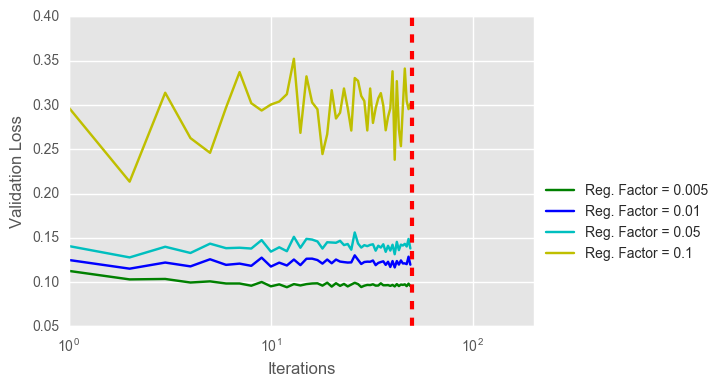

In [21]:
plt.figure()
plt.semilogx(range(len(avg_cost_early_stop[0])),avg_cost_early_stop[0],'g',label=u'Reg. Factor = 0.005')
plt.semilogx(range(len(avg_cost_early_stop[1])),avg_cost_early_stop[1],'b',label=u'Reg. Factor = 0.01')
plt.semilogx(range(len(avg_cost_early_stop[2])),avg_cost_early_stop[2],'c',label=u'Reg. Factor = 0.05')
plt.semilogx(range(len(avg_cost_early_stop[3])),avg_cost_early_stop[3],'y',label=u'Reg. Factor = 0.1')

plt.xlim([0,200])
plt.xlabel('Iterations')
plt.ylabel('Validation Loss')
plt.axvline(x=50, linewidth=3, color='r', ls='dashed')
plt.legend(loc='best', bbox_to_anchor=(1, 0.5))

In [22]:
test_losses = [test_model(i)for i in range(n_test_batches)]
test_score = np.mean(test_losses)
print('The test error was',test_score)

The test error was 0.0466666666667


By using an early stop function, a final test errror of approx. 4.7% was achieved. This was better than the approx. 9% test error provided by the logistic regression method.